In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import multiprocessing as mp
from elephant.statistics import instantaneous_rate
from neo import SpikeTrain
from brian2 import us
from utils.modulator import AsynchronousDeltaModulator, modulate
from utils.dataset import load_dataset
from utils.plotting import plot_sample
from quantities import s, Hz

In [44]:
settings = {
    'mod': 'BPSK',
    'snr': 18,
    'scale': 50,
    'thrup': 0.1,
    'thrdn': 0.1,
    'resampling_factor': 200,
    'stretch_factor': 1000,
}

In [3]:
dataset, classes = load_dataset('./data/radioML/RML2016.10a_dict.pkl', snr=settings['snr'], scale=settings['scale'], normalize=False)

In [26]:
modulations = np.unique(list(map(lambda x: x[0], classes)))

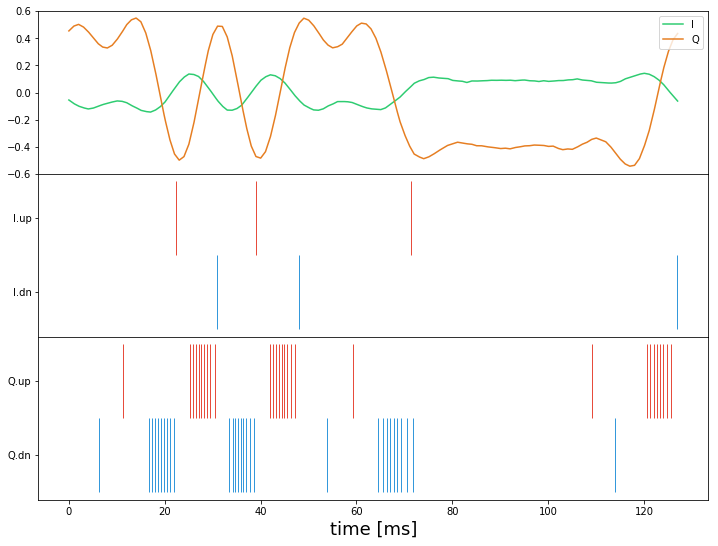

In [45]:
time_sample = np.arange(128)
sample = dataset[(settings['mod'], settings['snr'])][2]
modulators = [
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
]
indices, times, time_stim, signal = modulate(modulators[0], modulators[1], time_sample, sample, \
                                             resampling_factor=settings['resampling_factor'], \
                                             stretch_factor=settings['stretch_factor'])
plot_sample(signal, time_stim*us, indices, times*us, figsize=(12, 9))

In [5]:
def compute_firing_rate(indices, times):
    generators = np.unique(indices)
    firing_rates = {}
    tstart = 0.0*s
    tstop = (128*settings['stretch_factor']*1e-6)*s
    times = times*1e-6
    sampling_rate = (1*settings['stretch_factor']*1e-6)*s
    for g in generators:
        idx = np.where(indices==g)[0]
        st = SpikeTrain(times[idx]*s, t_start=tstart, t_stop=tstop)
        fr = instantaneous_rate(st, sampling_rate)
        firing_rates[g] = fr
    return firing_rates

In [46]:
firing_rates = compute_firing_rate(indices, times)

ValueError: Unable to calculate optimal kernel width for instantaneous rate from input data.

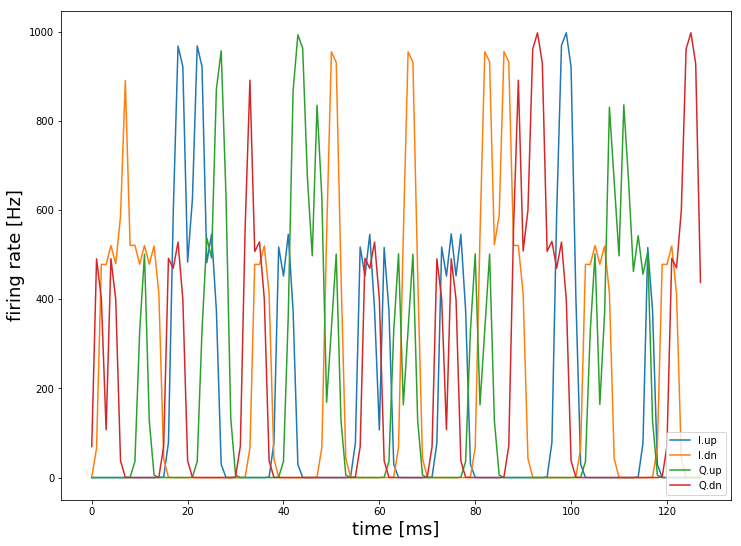

In [47]:
labels = ['I.up', 'I.dn', 'Q.up', 'Q.dn']
plt.figure(figsize=(12, 9))
for (g, fr) in firing_rates.items():
    plt.plot(time_sample, fr, label="{}".format(labels[g]))
plt.ylabel("firing rate [Hz]", fontsize=18)
plt.xlabel("time [ms]", fontsize=18)
plt.legend(loc="lower right")

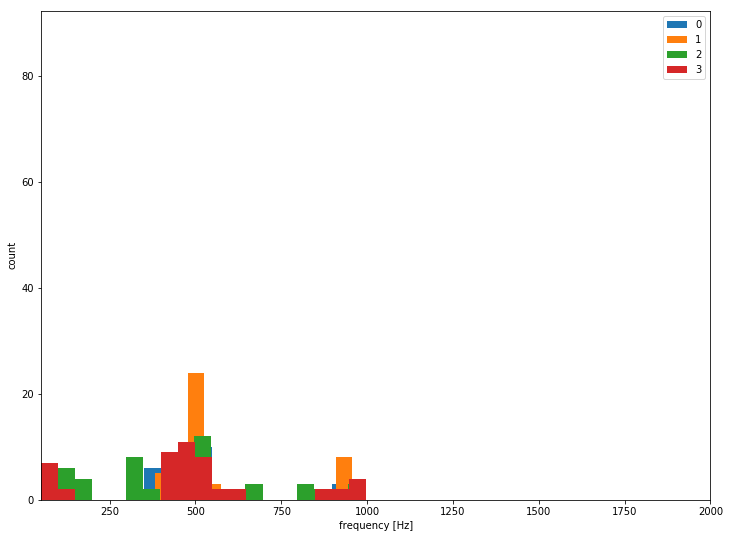

In [31]:
plt.figure(figsize=(12, 9))
for (g, fr) in firing_rates.items():
    plt.hist(fr/Hz, bins=20, label="{}".format(g))
plt.xlabel("frequency [Hz]")
plt.ylabel("count")
plt.xlim((50, 2000))
plt.legend(loc="best")

In [33]:
for (g, fr) in firing_rates.items():
    hist, edges = np.histogram(fr/Hz, bins=20, range=[50, 2000])
    idx = np.argmax(hist)
    print(edges[idx], edges[idx+1])

440.0 537.5
440.0 537.5
440.0 537.5
440.0 537.5


In [35]:
from tqdm import tqdm

In [38]:
M = 11
S = 100
most_common = np.zeros((M, S, 4))
for (i, mod) in tqdm(enumerate(modulations)):
    samples = dataset[(mod, settings['snr'])][:S]
    for (j, sample) in enumerate(samples):
        ix, tx, _, _ = modulate(modulators[0], modulators[1], time_sample, sample, \
                                resampling_factor=settings['resampling_factor'], stretch_factor=settings['stretch_factor'])
        firing_rates = compute_firing_rate(indices, times)
        for (g, fr) in firing_rates.items():
            hist, edges = np.histogram(fr/Hz, bins=20, range=[50, 2000])
            idx = np.argmax(hist)
            most_common[i, j, g] = edges[idx+1]




0it [00:00, ?it/s]


1it [01:43, 103.72s/it]


2it [03:28, 103.91s/it]


3it [05:12, 103.99s/it]


4it [06:56, 103.96s/it]


5it [08:40, 104.00s/it]


6it [10:24, 104.05s/it]


7it [12:08, 104.02s/it]


8it [13:52, 104.01s/it]


9it [15:36, 104.08s/it]


10it [17:20, 104.11s/it]


11it [19:05, 104.19s/it]